In [1]:
import os,random,itertools,matplotlib
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
# Umitools
from umi_tools._dedup_umi import edit_distance
matplotlib.rcParams['font.family'] = 'Helvetica'


def str2array(s):
    a,b= s.split('\t')[:2]
    return (a,int(b))

def merge_edit_1(counts):
    keep,collapse = [],counts[0:]
    while len(collapse)>0:
        ref = list(collapse[0]) # need to convert to list here otherwise will keep updating the value to new_cluster
        temp = []
        for s in collapse[1:]:
            s1 = ref[0]
            s2 = s[0]
            if abs(len(s1)-len(s2))<=1 and edit_distance(s1.encode('utf-8'),s2.encode('utf-8'))<2:
                ref[-1] += s[-1]
            else:
                temp.append(s)
        keep.append(ref)
        collapse = temp[0:]
    return np.array(keep,dtype=object)

def reverse_complement(seq):
    """This function returns the reverse_complement sequence of the input sequence
    from 3' to 5' """
    complement = {'A':'T', 'C':'G','G':'C', 'T':'A', 'N':'N','U':'A'}
    rcomp_seq = ''
    for base in seq:
        rcomp_seq = complement[base] + rcomp_seq   
    return rcomp_seq

def gen_min_edit(barcodes,array):
    temp=[]
    for a in array:
        temp.append(min([edit_distance(a.encode('utf-8'),s.encode('utf-8')) for s in barcodes if len(a) >1 ]))
    return temp

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

import re
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
%matplotlib inline


# Dose dependent recording

## Dox

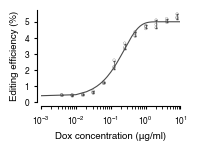

In [5]:
path = '../Figure3/dox/'
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s and 'neg' not in s])
ref = pd.DataFrame([('','WT'),('CTTCT','Dox')],columns = ['barcode','Sample'])
edits = []
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        df = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='left')
        df['ratio'] = df['count']/df['count'].sum()*100
    f.close()
    a,rep = s.split('_rep')
    sample = int(a.split('TRE-Dox-')[1])
    conc = 2**(sample-10) if sample >1 else 0
    edits.append([sample,conc,'rep'+rep,100-list(df[df['Sample']=='WT']['ratio'])[0]])
df_dox= pd.DataFrame(edits,columns=['Design','conc','rep','Editing efficiency'])

p0 = [5, 0.2,0.05,1]
popt, pcov = sp.optimize.curve_fit(sigmoid, df_dox['conc'], df_dox['Editing efficiency'],p0, method='lm',maxfev=10000)
x = np.linspace(0.00001, 100, 10000)
y = sigmoid(x, *popt)
fig, axs = fig, axs = plt.subplots(1,1,figsize=(1.8,1.2),sharey=False,sharex=False)

sns.lineplot(x=x,y=y,color ='#4A4A4A',linewidth = 0.8,ax=axs);
sns.lineplot(data=df_dox[df_dox['Design']>0],x="conc", y="Editing efficiency",linestyle='',color ='#4A4A4A',err_style='bars'\
             , err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',linewidth = 0.8,ax=axs)
sns.scatterplot(data=df_dox,x="conc", y="Editing efficiency",s=4,facecolors='none',edgecolor='#4A4A4A',
                legend=False,ax=axs)
sns.despine(offset=3)
axs.set_xscale('log',base=10)
axs.set_xlim(1e-3,1e1)
axs.set_yticks(np.arange(0, 6, 1))

axs.set_ylabel('Editing efficiency (%)',fontsize=7);
axs.set_xlabel('Dox concentration (\u03bcg/ml)',fontsize=7)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure3/fig/Fig_3b_dox.pdf')

## NFKB

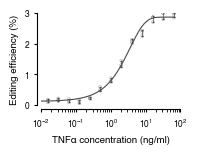

In [6]:
path = '../Figure3/nfkb/'
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s])
ref = pd.DataFrame([('','WT'),('TCCTA','NFKB'),('AATAA','NFKB')],columns = ['barcode','Sample'])
edits = []
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        df = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='left')
        df['ratio'] = df['count']/df['count'].sum()*100
        df = df[['Sample','ratio']].groupby('Sample').sum().reset_index()
    f.close()
    a,rep = s.split('_rep')
    sample = int(a.split('NFKB-TNFa-')[1])
    conc = 2**(sample-10) if sample >1 else 0
    edits.append([sample,conc,'rep'+rep,100-list(df[df['Sample']=='WT']['ratio'])[0]])
df_nfkb= pd.DataFrame(edits,columns=['Design','conc','rep','Editing efficiency'])



p0 = [3, np.median(df_nfkb['conc']),0.5,min(df_nfkb['Editing efficiency'])]
popt, pcov = sp.optimize.curve_fit(sigmoid, df_nfkb['conc'], df_nfkb['Editing efficiency'],p0, method='lm',maxfev=5000)
x = np.linspace(0.001, 65, 100000)
y = sigmoid(x, *popt)
fig, axs = fig, axs = plt.subplots(1,1,figsize=(1.8,1.2),sharey=False,sharex=False)

sns.lineplot(x=x,y=y,color ='#4A4A4A',linewidth = 0.8,ax=axs);
sns.lineplot(data=df_nfkb,x="conc", y="Editing efficiency",linestyle='',color ='#4A4A4A',err_style='bars'\
             , err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',linewidth = 0.8,ax=axs);
sns.scatterplot(data=df_nfkb,x="conc", y="Editing efficiency",s=4,facecolors='none',edgecolor='#4A4A4A',
                legend=False,ax=axs)
sns.despine(offset=3)
axs.set_xscale('log',base=10)
axs.set_xlim(1e-2,1e2)
axs.set_ylim(0,3)


axs.set_ylabel('Editing efficiency (%)',fontsize=7);
axs.set_xlabel('TNF\u03B1 concentration (ng/ml)',fontsize=7)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure3/fig/Fig_3c_nfkb.pdf')

## Wnt

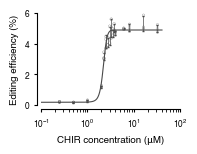

In [7]:
path = '../Figure3/wnt/'
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s])
concs = sorted([32,16,8,6,4,3.75,3.5,3.25,3,2.75,2.5,2.25,2,1,0.5,0.25])
ref = pd.DataFrame([('','WT'),('GCAAC','Wnt')],columns = ['barcode','Sample'])
edits = []
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        df = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='left')
        df['ratio'] = df['count']/df['count'].sum()*100
    f.close()
    a,rep = s.split('_rep')
    sample = int(a.split('TCF-CHIR-')[1])
    conc = concs[sample-1]
    edits.append([sample,conc,'rep'+rep,100-list(df[df['Sample']=='WT']['ratio'])[0]])
df_wnt= pd.DataFrame(edits,columns=['Design','conc','rep','Editing efficiency'])

p = [max(df_wnt['Editing efficiency']), np.median(df_wnt['conc']),1,min(df_wnt['Editing efficiency'])]
popt, pcov = sp.optimize.curve_fit(sigmoid, df_wnt['conc'], df_wnt['Editing efficiency'],p0, method='lm')
x = np.linspace(0, 40, 100000)
y = sigmoid(x, *popt)

fig, axs = fig, axs = plt.subplots(1,1,figsize=(1.8,1.2),sharey=False,sharex=False)
sns.lineplot(x=x,y=y,color ='#4A4A4A',linewidth = 0.8,ax=axs);
sns.lineplot(data=df_wnt,x="conc", y="Editing efficiency",linestyle='',markers='o',color ='#4A4A4A',err_style='bars'\
             , err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',linewidth = 0.8,ax=axs);
sns.scatterplot(data=df_wnt,x="conc", y="Editing efficiency",s=4,facecolors='none',edgecolor='#4A4A4A',
                legend=False,ax=axs)
sns.despine(offset=3);
axs.set_xscale('log',base=10);
axs.set_xlim(1e-1,1e2);
axs.set_ylim(0,6);
axs.set_ylabel('Editing efficiency (%)',fontsize=7);
axs.set_xlabel('CHIR concentration (\u03bcM)',fontsize=7)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure3/fig/Fig_3d_wnt.pdf')

## Baseline editing at day7 and day14

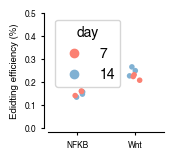

In [10]:
path = '../Figure3/baseline/'
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s and 'NFKB' in s])
ref = pd.DataFrame([('','WT'),('TCCTA','NFKB'),('AATAA','NFKB')],columns = ['barcode','Sample'])
edits = []
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        df = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='left')
        df['ratio'] = df['count']/df['count'].sum()*100
        df = df[['Sample','ratio']].groupby('Sample').sum().reset_index()
    f.close()
    a,rep = s.split('_rep')
    day = a.split('-TNFa-D')[1]
    edits.append(['NFKB','rep'+rep,int(day),100-list(df[df['Sample']=='WT']['ratio'])[0]])


samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s and 'CHIR' in s])
ref = pd.DataFrame([('','WT'),('GCAAC','Wnt'),('GTTGC','Wnt')],columns = ['barcode','Sample'])
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        df = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='left')
        df['ratio'] = df['count']/df['count'].sum()*100
    f.close()
    a,rep = s.split('_rep')
    day = int(a.split('TCF-CHIR-D')[1])
    edits.append(['Wnt','rep'+rep,day,100-list(df[df['Sample']=='WT']['ratio'])[0]])
df_baseline = pd.DataFrame(edits,columns=['Design','rep','day','Editing efficiency'])
fig, axs = plt.subplots(figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.stripplot(data = df_baseline, x='Design', y='Editing efficiency' ,palette=[ '#FB8072','#80B1D3'], order=['NFKB','Wnt'],hue='day',ax=axs,size=4)

axs.set_ylim(0,0.5)
axs.set_ylabel('Edidting efficiency (%)',fontsize=7)
axs.set_xlabel('',fontsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
sns.despine(offset=3)

#plt.savefig('../Figure3/fig/SuppFig6a_baseline.pdf')

##  Fold change

In [11]:
df_fold = pd.DataFrame(np.reshape(np.concatenate([np.array(df_dox[df_dox['Design']==16].iloc[:,3:])/np.array(df_dox[df_dox['Design']==1].iloc[:,3:]),\
                np.array(df_nfkb[df_nfkb['Design']==16].iloc[:,3:])/np.array(df_nfkb[df_nfkb['Design']==1].iloc[:,3:]),\
                np.array(df_wnt[df_wnt['conc']==32].iloc[:,3:])/np.array(df_wnt[df_wnt['conc']==0.25].iloc[:,3:])]),(3,3))).T
df_fold_melt = df_fold.melt()
df_fold_melt['design'] = ['Dox','Dox','Dox','TNFa','TNFa','TNFa','Wnt','Wnt','Wnt']
df_fold_melt['variable'] = 0

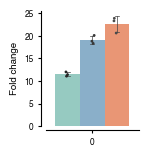

In [12]:
fig, axs = fig, axs = plt.subplots(1,1,figsize=(1.2,1.5),sharey=False,sharex=False)
g=sns.barplot(data=df_fold_melt,x='variable',y='value',hue='design',palette=['#8DD3C7','#80B1D3','#FC8D62'], errwidth=0.5, errorbar='sd', capsize=.05,ax=axs)
sns.stripplot(data=df_fold_melt, x="variable", y='value', hue="design", dodge=True,palette='dark:#4A4A4A',marker='.',size=4,ax=axs)

sns.despine(offset=3)
axs.set_ylabel('Fold change',fontsize=7);
axs.set_xlabel('')
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.legend_.remove()
#plt.savefig('../Figure3/fig/Fig_3e.pdf')

# Time_dose

## Time_dose Wnt

In [13]:
path = '../Figure3/time_dose_wnt/'
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s])
ref = pd.DataFrame([('','WT'),('GTTGC','Wnt')],columns = ['barcode','Sample'])
concs = sorted([2.6,2.4,2.2,2,1.8,1.6,1.4,1.2,1])
edits = []
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        df = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='left')
        df['ratio'] = df['count']/df['count'].sum()*100
    f.close()
    a,rep = s.split('_rep')
    b,day = a.split('_')
    sample = int(b.split('TCF-CHIR-')[1])
    conc = concs[int(sample)-1]
    edits.append([conc,int(day[:-1]),'rep'+rep,100-list(df[df['Sample']=='WT']['ratio'])[0]])
df_wnt = pd.DataFrame(edits,columns=['conc','time','rep','Editing efficiency'])

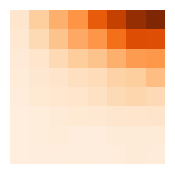

In [14]:
df_plot =df_wnt.sort_values(by='time').groupby(['conc','time'],as_index=False ).mean(numeric_only=True).pivot(index='conc',columns='time').sort_values('conc',axis=0,ascending=False)
fig, axs = fig, axs = plt.subplots(1,1,figsize=(2,2),sharey=False,sharex=False)
sns.heatmap(df_plot,ax=axs,cmap='Oranges',vmin=0, vmax=4,cbar=False)
axs.set_xticks([]);
axs.set_yticks([]);
axs.set_xlabel('');
axs.set_ylabel('');
#plt.savefig('../Figure3/fig/Fig3g_heatmap_wnt.pdf')


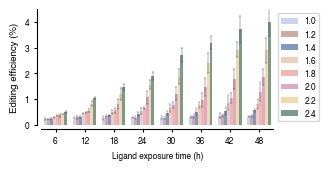

In [15]:
fig, axs = fig, axs = plt.subplots(1,1,figsize=(3,1.5),sharey=False,sharex=False)
g=sns.barplot(data=df_wnt,x="time", y="Editing efficiency",hue='conc',errwidth=0.3, errorbar='sd', capsize=.06,\
              palette=['#C7CEF6','#D8A49B','#7496D2','#F5CDB6','#F7B0AA','#E6A2C5','#FDDDA4','#76A08A','#9A872D'],ax=axs)
g.legend(loc='upper left', bbox_to_anchor=(1, 1),prop={'size': 6})
sns.despine(offset=3)
axs.set_ylabel('Editing efficiency (%)',fontsize=7);
axs.set_xlabel('Ligand exposure time (h)',fontsize=6)
axs.set_ylim(0,4.5)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure3/fig/SuppFig6c.pdf')


## Time_dose NFKB

In [16]:
path = '../Figure3/time_dose_nfkb/'
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s])
ref = pd.DataFrame([('','WT'),('TCCTA','NFKB'),('AATAA','NFKB')],columns = ['barcode','Sample'])
concs = [0.25,0.5,1,2,4,8,16,32]
edits = []
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        df = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='left')
        df['ratio'] = df['count']/df['count'].sum()*100
        df = df[['Sample','ratio']].groupby('Sample').sum().reset_index()
    f.close()
    a,rep = s.split('_rep')
    b,day = a.split('_')
    sample = int(b.split('NFKB-TNFa-')[1])
    conc = concs[int(sample)-1]
    edits.append([conc,int(day[:-1]),'rep'+rep,100-list(df[df['Sample']=='WT']['ratio'])[0]])
df_nfkb = pd.DataFrame(edits,columns=['conc','time','rep','Editing efficiency'])

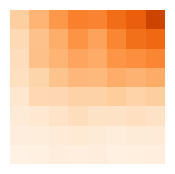

In [17]:
df_plot_nfkb =df_nfkb.sort_values(by='time').groupby(['conc','time'],as_index=False ).mean(numeric_only=True).pivot(index='conc',columns='time').sort_values('conc',axis=0,ascending=False)

fig, axs = fig, axs = plt.subplots(1,1,figsize=(2,2),sharey=False,sharex=False)
sns.heatmap(df_plot_nfkb,ax=axs,cmap='Oranges',vmin=0, vmax=4,cbar=False)
axs.set_xticks([]);
axs.set_yticks([]);
axs.set_xlabel('');
axs.set_ylabel('');
#plt.savefig('../Figure3/fig/Fig3f_heatmap_nfkb.pdf')


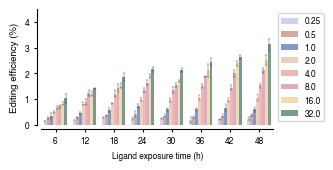

In [18]:
fig, axs = fig, axs = plt.subplots(1,1,figsize=(3,1.5),sharey=False,sharex=False)
g=sns.barplot(data=df_nfkb,x="time", y="Editing efficiency",hue='conc',errwidth=0.3, errorbar='sd', capsize=.06,\
              palette=['#C7CEF6','#D8A49B','#7496D2','#F5CDB6','#F7B0AA','#E6A2C5','#FDDDA4','#76A08A','#9A872D'])
g.legend(loc='upper left', bbox_to_anchor=(1, 1),prop={'size': 6})
sns.despine(offset=3)
axs.set_ylim(0,4.5)
axs.set_ylabel('Editing efficiency (%)',fontsize=7);
axs.set_xlabel('Ligand exposure time (h)',fontsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure3/fig/SuppFig_6b.pdf')

# Multiplexing Figure 3i

In [19]:
path = '../Figure3/multiplex/'
conditions = ['neg-ctrl', 'Dox', 'TNFa', 'CHIR', 'Dox-TNFa','Dox-CHIR','TNFa-CHIR', 'Dox-TNFa-CHIR' ]
ref = pd.DataFrame([('','WT'),('AGAAG','Dox'),('TCCTA','NFKB'),('AATAA','NFKB'),('GCAAC','Wnt')],columns = ['barcode','Sample'])
matrix = np.empty([3,8])
for i in range(8):    
    df_temp = pd.DataFrame(['WT','Dox','NFKB','Wnt'],columns = ['Sample'])
    for j in range(3):
        with open(path+'293T-'+ conditions[i]+ '_rep' + str(j+1) +'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = ref.merge(pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']),on='barcode',how='inner')[['Sample','count']].groupby('Sample',sort=False).sum().reset_index()
            test['ratio']=test['count']/test['count'].sum()*100
            df_temp = df_temp.merge(test[['Sample','ratio']],on='Sample')
        f.close()
    matrix[:,i] = df_temp.loc[1:,['ratio_x','ratio_y','ratio']].mean(axis=1)

[]

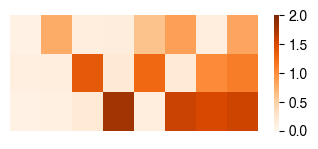

In [20]:
fig, axs = fig, axs = plt.subplots(1,1,figsize=(4,1.5),sharey=False,sharex=False)
sns.heatmap(matrix,ax=axs,cmap='Oranges',vmin=0, vmax=2.)
axs.set_xlabel('');
axs.set_ylabel('')
axs.set_xticks([])
axs.set_yticks([])
#plt.savefig('../Figure3/Fig_3i.pdf')

In [21]:
df_matrix = pd.DataFrame(matrix,columns=['neg-ctrl', 'Dox', 'TNFa', 'CHIR', 'Dox-TNFa','Dox-CHIR','TNFa-CHIR', 'Dox-TNFa-CHIR' ],\
                         index=['Dox','TNFa','Wnt'])
df_matrix

,neg-ctrl,Dox,TNFa,CHIR,Dox-TNFa,Dox-CHIR,TNFa-CHIR,Dox-TNFa-CHIR
Dox,0.062923,0.76581,0.117181,0.137012,0.601087,0.860524,0.114314,0.814019
TNFa,0.100369,0.11432,1.369776,0.201068,1.255134,0.187730,1.016883,1.109756
Wnt,0.068451,0.09228,0.188331,1.785085,0.112334,1.570019,1.507601,1.561234


In [22]:
df_fold_change = (df_matrix.T/df_matrix['neg-ctrl']).T
df_fold_change

,neg-ctrl,Dox,TNFa,CHIR,Dox-TNFa,Dox-CHIR,TNFa-CHIR,Dox-TNFa-CHIR
Dox,1.0,12.170581,1.862290,2.177447,9.552734,13.675809,1.816733,12.936743
TNFa,1.0,1.138992,13.647369,2.003281,12.505168,1.870394,10.131422,11.056732
Wnt,1.0,1.348106,2.751309,26.078195,1.641075,22.936305,22.024453,22.807968


## Supp 6f

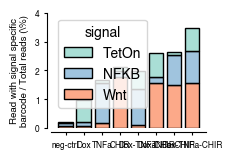

In [23]:
df_new = df_matrix.melt().reset_index(drop=True)
df_new['signal']=['TetOn','NFKB','Wnt']*8
df_new['comb']=[len(a.split('-')) for a in df_new['variable']]

fig, axs = fig, axs = plt.subplots(1,1,figsize=(2,1.5),sharey=False,sharex=False)
sns.histplot(df_new, x='variable', hue='signal',  weights='value',multiple='stack',shrink=0.8,\
             palette=['#8DD3C7','#80B1D3','#FC8D62'],ax=axs)
sns.despine(offset=3)
axs.set_ylim(0,4)
axs.set_ylabel('Read with signal specific\nbarcode / Total reads (\%)',fontsize=7);
axs.set_xlabel('')
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure3/fig/SuppFig_6f.pdf')

## Combi Supp Fig 6 gh

In [24]:
orders = [333,323,313,
          332,322,312,
          331,321,311,
          233,223,213,
          232,222,212,
          231,221,211,
          133,123,113,
          132,122,112,
          131,121,111]
groups = {'11':0,'21':1,'31':2
          ,'12':3,'22':4,'32':5
          ,'13':6,'23':7,'33':8}

In [25]:
path = '../Figure3/multiplex_conc_combi/' # run on two runs has both R1 and R2
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s and 'combi' in s])

In [26]:
ref = pd.DataFrame([('','WT'),('CTTCT','Dox'),('TAGGA','NFKB'),('TTATT','NFKB'),('GTTGC','Wnt'),
                   ('AGAAG','Dox'),('TCCTA','NFKB'),('AATAA','NFKB'),('GCAAC','Wnt')],columns = ['barcode','Sample'])

In [27]:
df=pd.DataFrame([],columns=['Sample','conc','group','sub_group','rep','count','ratio'])
for s in samples: 
    file = path+s
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0]) ==0 or len(a[0]) ==5]),columns=['barcode','count']).merge(ref,how='inner').groupby('Sample',sort=False,as_index=False).sum()[['Sample','count']]
        test['ratio']=test['count']/test['count'].sum()*100
    f.close()
    a,rep = s.split('_rep')
    combi = a.split('-conc-combi-')[1]
    signals = pd.DataFrame({'Sample':['Dox','NFKB','Wnt'],'conc':[int(s) for s in combi],'group':groups[combi[1:]],\
                            'sub_group':int(combi[0]),'rep':rep}).merge(test)
    df = pd.concat([df,signals])

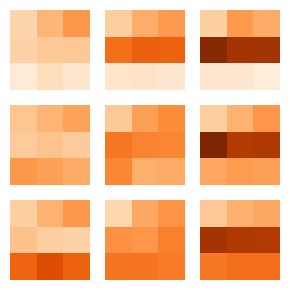

In [28]:
fig, axs = fig, axs = plt.subplots(3,3,figsize=(3,3))
k=0
for i in range(3):
    for j in range(3):
        mat = df[df['group']==k].groupby(['Sample','sub_group'],as_index=False).mean().\
                          pivot(index='Sample',columns='sub_group',values='ratio').reset_index().iloc[:,1:].astype(float)
        sns.heatmap(mat,cmap='Oranges',vmin=0,vmax=1,ax=axs[i,j],cbar=False)
        axs[i,j].set_xticks([]);
        axs[i,j].set_yticks([]);
        axs[i,j].set_xlabel('');
        axs[i,j].set_ylabel('');
        k+=1
        if j==2:
            j=0
            i+=1
            break
        j+=1
plt.tight_layout()

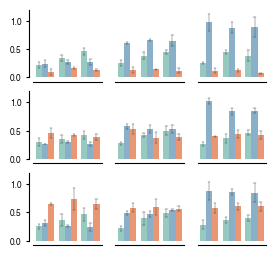

In [29]:
fig, axs = fig, axs = plt.subplots(3,3,figsize=(3,3),sharey=True)
k=0
for i in range(3):
    for j in range(3):
        g=sns.barplot(data=df[df['group']==k],x="sub_group", y="ratio",hue='Sample',errwidth=0.3, \
                      palette=['#8DD3C7','#80B1D3','#FC8D62'],\
                      errorbar='sd', capsize=.1,ax=axs[i,j])
        #g.legend(loc='upper left', bbox_to_anchor=(1, 1),prop={'size':1})
        g.legend([],[], frameon=False)
        
        axs[i,j].set_ylim(0,1.2)
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('')
        axs[i,j].set_xticks([]);
        
        axs[i,j].xaxis.set_tick_params(width=0, length=0,labelsize=6)
        if j!=0:
            sns.despine(ax=axs[i,j],left=True,offset=3)
            axs[i,j].yaxis.set_tick_params(width=0, length=0,labelsize=6)
        else:
            sns.despine(ax=axs[i,j],offset=3)
            axs[i,j].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
        k+=1
        if j==2:
            j=0
            i+=1
            break
        j+=1

# MOI quantification Supp Fig6d

In [30]:
moi = pd.read_csv('../Figure3/PB_MOI_quantification_processed.csv')

In [31]:
moi['copy'] = 2*2**(-moi['value'])
moi_gfp= moi[(moi['primer'].str.contains('GFP'))].reset_index(drop=True) # &(moi['Sample']!='a')

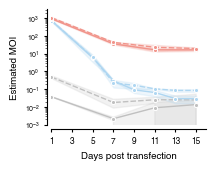

In [37]:
fig, axs = plt.subplots(1,figsize=(2,1.5),sharey=False,sharex=False)
g=sns.lineplot(data=moi_gfp,x="Day", y="copy",hue='Sample',style='primer',palette=['#C0C0C0','#aed6f1','#f1948a'],\
               markers=['.','.'],linewidth = 1,errorbar='sd',ax=axs)
axs.set_xlabel('Days post transfection',fontsize=7);
axs.set_ylabel('Estimated MOI',fontsize=7)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(which='major',width=0.8, length=2,labelsize=5)
axs.yaxis.set_tick_params(which='minor',width=0.4, length=1.5,labelsize=0)

axs.set_xlim(1,16)
axs.set_ylim(10**(-3),10**3.5)
#axs.axes.axhline(10**(1.3),color = '#4A4A4A',**{'linestyle':'--','lw':0.8})
axs.xaxis.set_ticks(np.arange(1, 16, 2))
axs.set_yscale('log',base=10)
g.legend_.remove()
sns.despine(offset=3)